In [2]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

import transformer_lens

from probe_model import LinearProbe, Trainer, TrainerConfig

In [2]:
# helpful to reload probe_model after making changes to probe_model.py
import importlib
import probe_model
importlib.reload(probe_model)
from probe_model import LinearProbe, Trainer, TrainerConfig

## Setup

In [3]:
device_name = "cpu"
if torch.cuda.is_available():
    device_name = "cuda" # CUDA for NVIDIA GPU

device = torch.device(device_name)
print(f"Device: {device_name}")

Device: cuda


In [4]:
model_name = "gpt2-small"
model = transformer_lens.HookedTransformer.from_pretrained(model_name)

Loaded pretrained model gpt2-small into HookedTransformer


## Generate dataset

### Load text

In [5]:
N_WORDS = 10000
with open('datasets/common_words.txt', 'r') as file:
    words = np.random.choice([l.rstrip("\n") for l in file.readlines()], N_WORDS)
    
word_len_dict = {w: len(model.to_tokens(f" {w}", prepend_bos=False).squeeze(0)) for w in words}
word_len = np.vectorize(lambda x: word_len_dict[x])

### generating

In [6]:
PREFIX = "Hello and welcome to my blog, where I love to list words.\nWhat "
BATCH_SIZE = 256
N_SAMPLE = 10

prefix_len = len(model.to_tokens(PREFIX, prepend_bos=True).squeeze(0)) - 1

def generate_batch():
    batch_words = []
    for i in range(BATCH_SIZE):
        sampled = np.random.choice(words, N_SAMPLE)

        batch_words.append(sampled)

    tokens = model.to_tokens([PREFIX + " ".join(s) for s in batch_words], prepend_bos=True)
    mapped_len = word_len(batch_words)

    word_idxs = np.ones((BATCH_SIZE, N_SAMPLE * 3)) * -1
    for i, r in enumerate(mapped_len):
        row = np.repeat(np.arange(N_SAMPLE), r)
        word_idxs[i, :len(row)] = row

    return tokens, word_idxs

In [8]:
# print example
PREFIX + " ".join(np.random.choice(words, N_SAMPLE))

'Hello and welcome to my blog, where I love to list words.\nWhat james n logical purple target servers joshua flight remained endorsed'

In [10]:
DATA_BATCHES = 200

torch.set_grad_enabled(False)

all_resids = []
all_word_idxs = []

for i_batch in tqdm(range(DATA_BATCHES)):
    tokens, word_idxs = generate_batch()
    _, cache = model.run_with_cache(tokens, names_filter=lambda x: x.endswith("resid_post"))
    residuals = cache.stack_activation("resid_post")

    # residuals.shape = (layer, batch, seq_len, model_residual_dimension)
    residuals = residuals[:, :, prefix_len:, :]
    word_idxs = word_idxs[:, :residuals.size(dim=2)]

    mask = word_idxs != -1

    all_resids.append(residuals.cpu().numpy()[:, mask].reshape(12, -1, model.cfg.d_model))
    all_word_idxs.append(word_idxs[mask])


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


In [11]:
x_all_layers = np.concatenate(all_resids, axis=1)
y = np.concatenate(all_word_idxs)

print(x_all_layers.shape)
print(y.shape)

(12, 631041, 768)
(631041,)


## Training Probes

In [12]:
class ProbingDataset(Dataset):
    def __init__(self, act, y):
        assert len(act) == len(y)
        print(f"dataset: {len(act)} pairs loaded...")
        self.act = act
        self.y = y
        print("y:", np.unique(y, return_counts=True))
        
    def __len__(self, ):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.tensor(self.act[idx]), torch.tensor(self.y[idx]).long()

In [18]:
LAYER = 3
x = x_all_layers[LAYER, :, :]

probing_dataset = ProbingDataset(x, y)
train_size = int(0.8 * len(probing_dataset))
test_size = len(probing_dataset) - train_size
probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])
print(f"split into [test/train], [{test_size}/{train_size}]")

dataset: 631041 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([63242, 63205, 63201, 62939, 63081, 62971, 62844, 63303, 63211,
       63044]))
split into [test/train], [126209/504832]


In [19]:
probe = LinearProbe(device, 768, 10)

folder = f"ckpts/{model_name}/randwords_631k/layer{LAYER}"
config = TrainerConfig(num_epochs=40, ckpt_path=folder)
trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

In [20]:
trainer.train()

Epoch 40; Train Loss: 0.59537; Train Acc: 74.915%; Test Acc: 74.915%: 100%|██████████| 40/40 [06:39<00:00,  9.98s/it]


In [23]:
print(trainer.generate_report())

              precision    recall  f1-score   support

           0     0.9912    0.9959    0.9935     12553
           1     0.9620    0.9671    0.9646     12656
           2     0.9077    0.8955    0.9016     12620
           3     0.8185    0.8199    0.8192     12669
           4     0.7570    0.6697    0.7107     12514
           5     0.6058    0.7790    0.6815     12582
           6     0.6451    0.4498    0.5300     12628
           7     0.5346    0.7044    0.6079     12772
           8     0.5679    0.4098    0.4761     12609
           9     0.7340    0.8009    0.7660     12606

    accuracy                         0.7492    126209
   macro avg     0.7524    0.7492    0.7451    126209
weighted avg     0.7521    0.7492    0.7450    126209



### plotting loss curves

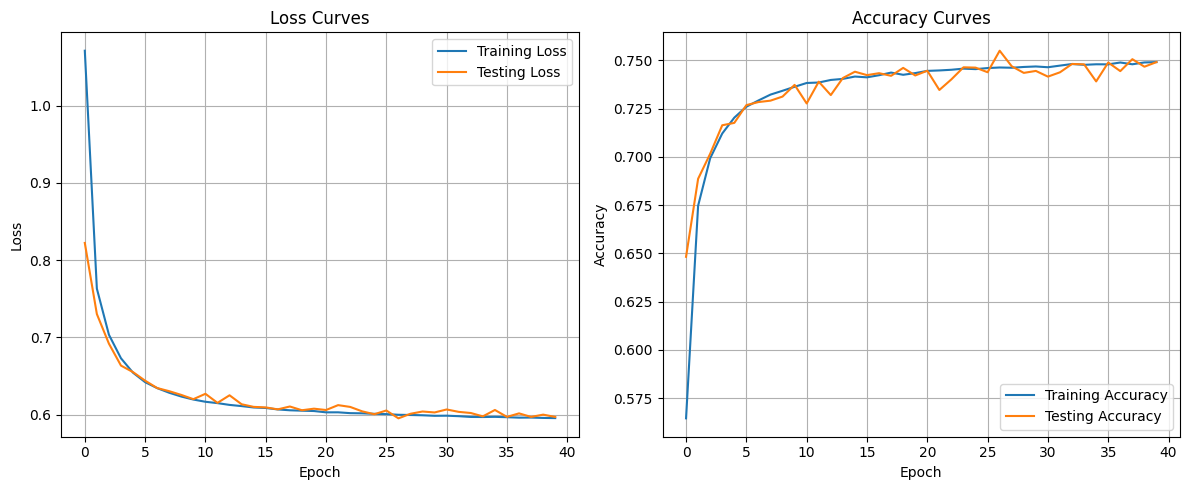

In [22]:
metrics_path = os.path.join(folder, 'metrics.json')

# Load the metrics from the JSON file
with open(metrics_path, 'r') as f:
    metrics = json.load(f)['metrics']

# Extract the loss and accuracy data
train_loss = metrics['train_loss']
test_loss = metrics['test_loss']
train_acc = metrics['train_acc']
test_acc = metrics['test_acc']

# Plot the loss curves
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### training on all layers

In [22]:
for LAYER in range(x_all_layers.shape[0]):
    print(f"LAYER: {LAYER}")
    x = x_all_layers[LAYER, :, :]

    probing_dataset = ProbingDataset(x, y)
    train_size = int(0.8 * len(probing_dataset))
    test_size = len(probing_dataset) - train_size
    probe_train_dataset, probe_test_dataset = torch.utils.data.random_split(probing_dataset, [train_size, test_size])

    probe = LinearProbe(device, 768, 10)

    folder = f"ckpts/{model_name}/randwords_159k/layer{LAYER}"
    config = TrainerConfig(num_epochs=40, ckpt_path=folder)
    trainer = Trainer(device, probe, probe_train_dataset, probe_test_dataset, config)

    trainer.train()

LAYER: 0
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.94915; Train Acc: 59.041%; Test Acc: 58.168%: 100%|██████████| 40/40 [01:43<00:00,  2.58s/it]


LAYER: 1
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.73077; Train Acc: 70.257%; Test Acc: 68.958%: 100%|██████████| 40/40 [01:43<00:00,  2.60s/it]


LAYER: 2
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.62059; Train Acc: 74.773%; Test Acc: 73.328%: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


LAYER: 3
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.61062; Train Acc: 74.305%; Test Acc: 71.535%: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


LAYER: 4
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.60751; Train Acc: 73.808%; Test Acc: 71.901%: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


LAYER: 5
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.60988; Train Acc: 73.448%; Test Acc: 71.438%: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


LAYER: 6
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.62943; Train Acc: 72.048%; Test Acc: 70.889%: 100%|██████████| 40/40 [01:44<00:00,  2.60s/it]


LAYER: 7
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.67216; Train Acc: 69.694%; Test Acc: 68.508%: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


LAYER: 8
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.72806; Train Acc: 67.135%; Test Acc: 66.630%: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


LAYER: 9
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.79549; Train Acc: 64.063%; Test Acc: 62.641%: 100%|██████████| 40/40 [01:44<00:00,  2.60s/it]


LAYER: 10
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 0.88918; Train Acc: 60.145%; Test Acc: 58.442%: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


LAYER: 11
dataset: 158702 pairs loaded...
y: (array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([15838, 15867, 15879, 15940, 15850, 15918, 15853, 15854, 15869,
       15834]))


Epoch 40; Train Loss: 1.14027; Train Acc: 51.487%; Test Acc: 50.792%: 100%|██████████| 40/40 [01:43<00:00,  2.60s/it]


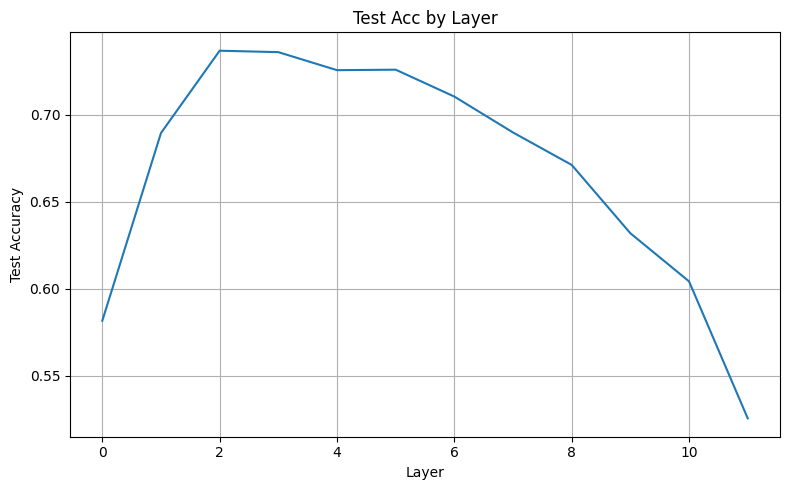

In [3]:
by_layer = []
for i in range(12):
    with open(f"ckpts/gpt2-small/randwords_159k/layer{i}/metrics.json", 'r') as f:
        metrics = json.load(f)['metrics']
        best = max(metrics['test_acc'])
        by_layer.append(best)

plt.figure(figsize=(8, 5))

plt.plot(by_layer)
plt.title('Test Acc by Layer')
plt.xlabel('Layer')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()